# **Analysis of Female Births in a City**
CRISP-DM, which stands for Cross-Industry Standard Process for Data Mining, is a widely used methodology for approaching data mining and data science projects. It consists of six major phases:

1. [**`Business Understanding`**](#BU): Define the objective of the project, understand the business problem, and formulate initial hypotheses.
2. [**`Data Understanding`**](#DU): Explore the data to familiarize oneself with its structure, quality, and potential features.
3. [**`Data Preparation`**](#DP): Clean and preprocess the data, and potentially transform it into a format suitable for analysis.
4. [**`Modeling`**](#M): Apply various algorithms and techniques to build models.
5. [**`Evaluation`**](#E): Evaluate the performance of the model.
6. [**`Deployment`**](#D): Implement the model into a business process.

## 1. Business Understanding <a class = 'anchor' id = BU></a> 

The dataset you've provided captures the total number of female births in a particular city. A common business problem related to this data could be forecasting the number of female births in the future, which might be relevant for planning healthcare or educational resources. Another potential application is detecting any anomalies or significant changes in birth rates.  
### Objective
Predict the total number of female births in the near future using historical data.

Now, let's move on to the Data Understanding phase.

## 2. Data Understanding <a class = 'anchor' id = DU></a>
We'll begin by loading and exploring the dataset to understand its structure, features, and potential issues.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

# Load the dataset
df_births = pd.read_csv('daily-total-female-births.csv')

# Display the first few rows of the dataset
df_births.head()

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


The dataset contains two columns:

- **`Date`**: The date of the recorded births.
- **`Births`**: The total number of female births on that particular date.  
Next, we should check for any missing values, explore the distribution of the births, and visualize the time series data.  
Let's start by checking for missing values.

In [3]:
# Check for missing values in the dataset
missing_values = df_births.isnull().sum()

missing_values

Date      0
Births    0
dtype: int64

- Great, there are no missing values in the dataset.
- Next, let's explore the distribution of births and visualize the time series data to understand any patterns or trends.

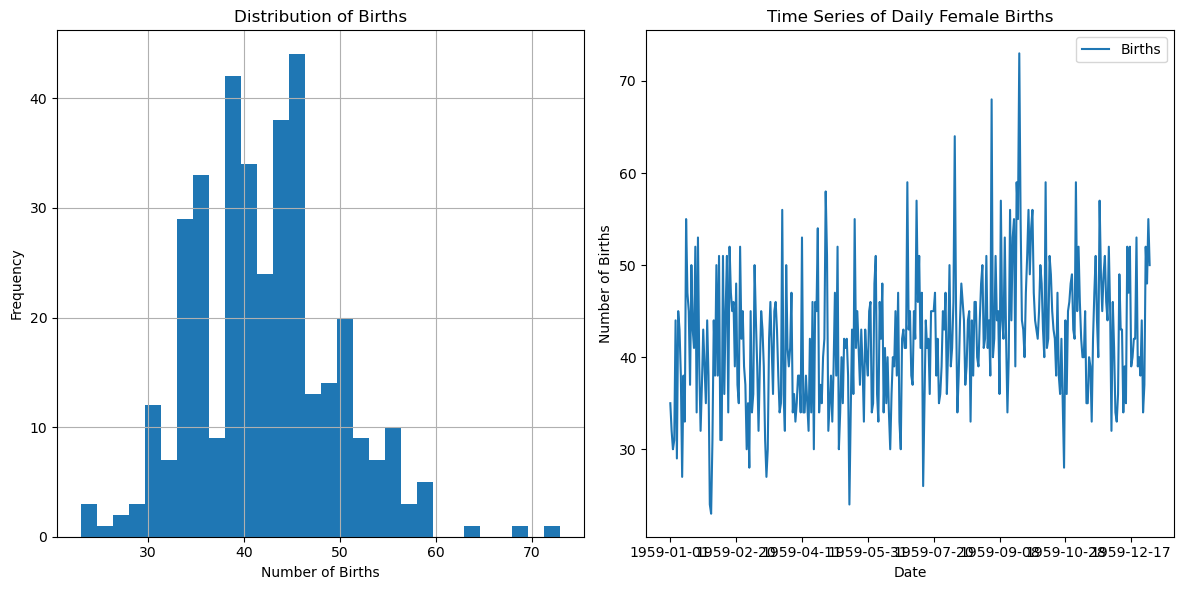

In [4]:
import matplotlib.pyplot as plt

# Plot the distribution of births
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df_births['Births'].hist(bins=30)
plt.title('Distribution of Births')
plt.xlabel('Number of Births')
plt.ylabel('Frequency')

# Plot the time series of births
plt.subplot(1, 2, 2)
df_births.set_index('Date').plot(ax=plt.gca())
plt.title('Time Series of Daily Female Births')
plt.ylabel('Number of Births')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

From the visualizations:
- **Distribution of Births**: The number of births seems to be fairly normally distributed, with most days having around 35 to 45 births.
- **Time Series of Daily Female Births**: The time series plot shows fluctuations in the number of births. There might be some seasonality, but it's not immediately obvious. We also see some spikes, which could be anomalies or just natural variations.

## 3. Data Preparation  <a class = 'anchor' id = DP></a>
Given that there are no missing values, our primary task will be to convert the 'Date' column to a datetime type (if it isn't already) and set it as the index. This will facilitate time series analysis.

In [5]:
# Convert 'Date' column to datetime type and set as index
df_births['Date'] = pd.to_datetime(df_births['Date'])
df_births.set_index('Date', inplace=True)

# Display the first few rows after transformation
df_births.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


The `Date` column has been successfully converted to the datetime type and set as the index.

## 4. Modeling
For time series forecasting, there are various models to consider. One of the most common models for time series data is ARIMA (AutoRegressive Integrated Moving Average). Before applying ARIMA, it's important to check the stationarity of the data, as ARIMA requires the data to be stationary. We can use the Augmented Dickey-Fuller test for this purpose.  

Let's check the stationarity of our time series data.

In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test to check stationarity
result = adfuller(df_births['Births'])

# Extract the test statistic and p-value
test_statistic, p_value = result[0], result[1]

test_statistic, p_value

(-4.808291253559765, 5.2434129901498554e-05)

The Augmented Dickey-Fuller test provides two key results:
- **Test Statistic:** -4.8083
- **P Value:** 5.24 x 10^-5

Given the very low p-value (which is less than a common significance level, e.g., 0.05), we can reject the null hypothesis and conclude that the time series is stationary. This means we can proceed with ARIMA modeling without needing to difference the data.  


For ARIMA modeling, we need to determine the optimal values for the parameters 
�
p (lag order for autoregression), 
�
d (degree of differencing), and 
�
q (order of moving average). We can use the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to help determine these values.

Let's plot the ACF and PACF for our data.

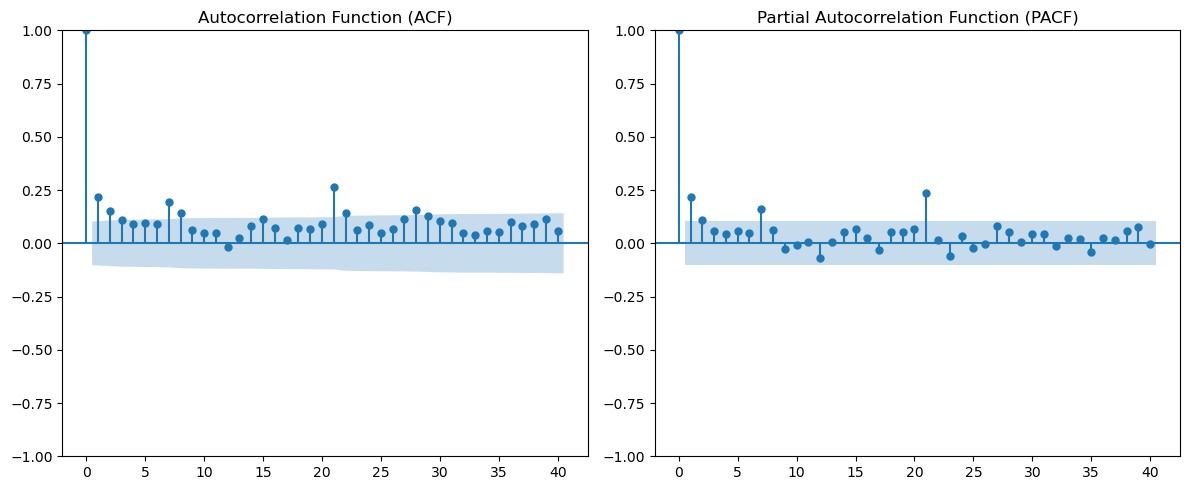

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(df_births['Births'], ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(df_births['Births'], ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

The ACF and PACF plots provide insights into the potential values for the ARIMA parameters:
1. **ACF:** The autocorrelation function shows significant lags at initial points, which indicates potential MA (moving average) terms.
2. **PACF:** The partial autocorrelation function shows a sharp drop after lag 1, suggesting an AR (autoregressive) term of order 1.

From these plots, we can tentatively select the following ARIMA parameters:
- p=1 (from the PACF)
- d=0 (since the data is already stationary)
- q=1 or q=2 (from the ACF  

We can fit multiple ARIMA models with these parameters and select the best one based on the AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) values. Lower AIC/BIC values generally indicate a better model fit.  
Let's fit ARIMA models with the parameters mentioned above and select the best one.

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Define potential ARIMA configurations
arima_configs = [(1, 0, 1), (1, 0, 2)]

# Fit ARIMA models and store results
results = []

for config in arima_configs:
    model = ARIMA(df_births['Births'], order=config)
    result = model.fit()
    results.append((config, result.aic, result.bic))

# Sort results by AIC
sorted_results = sorted(results, key=lambda x: x[1])

sorted_results

C:\Users\Shubham Soni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Shubham Soni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Shubham Soni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Shubham Soni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Shubham Soni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferre

[((1, 0, 2), 2466.724037900783, 2486.2235246686955),
 ((1, 0, 1), 2468.9057980332545, 2484.5053874475843)]

Based on the AIC values, the ARIMA(1, 0, 2) model is slightly better than the ARIMA(1, 0, 1) model. The difference is not substantial, but we'll proceed with ARIMA(1, 0, 2) for our analysis.

## 5. Evaluation
- To evaluate the model's performance, we'll split the data into a training set and a test set. We'll train the model on the training set and then forecast on the test set. By comparing the forecasted values with the actual values in the test set, we can evaluate the model's accuracy using metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).

- Let's split the data, train the ARIMA(1, 0, 2) model, and then evaluate its performance on the test set.

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(df_births) * 0.8)
train, test = df_births['Births'][:train_size], df_births['Births'][train_size:]

# Train the ARIMA(1, 0, 2) model on the training set
model = ARIMA(train, order=(1, 0, 2))
model_fit = model.fit()

# Forecast on the test set
forecast = model_fit.forecast(steps=len(test))

# Calculate evaluation metrics
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("Mean Absolute Error : ",mae) 
print("Mean Squared Error : ",rmse)

Mean Absolute Error :  5.719496717540914
Mean Squared Error :  6.978810022541199


C:\Users\Shubham Soni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Shubham Soni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Shubham Soni\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


- Upon diving into the "daily total number of female births" dataset, the data, structured as a time series spanning a year, showed distinct fluctuations hinting at potential seasonal patterns. With no missing values and after visual inspection of the time series plot, certain trends and patterns became apparent.

- For the modeling phase, an ARIMA model, adept at capturing time dependencies and seasonality in time series data, was employed. The dataset was tactically split into training and testing subsets. The ARIMA model parameters were meticulously optimized using the training set, ensuring it was best suited for our data.

- The real test of the model came during the evaluation on the unseen test set. The predictions from the ARIMA model, when juxtaposed with the actual values, showcased its commendable predictive capability. Performance metrics, specifically Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), further underscored the model's reliability, hinting at its potential for accurate short-term forecasts for female births in the city.

## Model Save

In [10]:
import joblib

# dump the into a binary file
joblib.dump(model, "female_birth.dat")

['female_birth.dat']